In [1]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 40.2MB/s 
     |████████████████████████████████| 501kB 49.2MB/s 
     |████████████████████████████████| 3.1MB 27.1MB/s 


In [0]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


In [2]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:



"""def lr_schedule(epoch):
   
    lr = 5e-3
    if epoch > 180:
        lr *= 0.5e-1
    elif epoch > 160:
        lr *= 1e-1
    elif epoch > 120:
        lr *= 1e-1
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr"""


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




In [4]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=.9),
              metrics=['categorical_crossentropy','accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
#checkpoint = ModelCheckpoint(filepath=filepath,
#                             monitor='val_acc',
#                             verbose=1,
#                             save_best_only=True)

#lr_scheduler = LearningRateScheduler(lr_schedule)

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                               cooldown=0,
#                               patience=5,
#                               min_lr=0.5e-6)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
def scheduler(epoch):
  if epoch >=70:
    return 1e-5
  elif epoch >=20:
    return 1e-4
  else:
    return 5e-3

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=150,
              validation_data=(x_test, y_test),
              callbacks=[callback],
              shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 78s 2ms/sample - loss: 2.4653 - categorical_crossentropy: 1.8578 - accuracy: 0.3175 - val_loss: 2.3050 - val_categorical_crossentropy: 1.6998 - val_accuracy: 0.3685
Epoch 2/150
50000/50000 [==============================] - 67s 1ms/sample - loss: 2.1891 - categorical_crossentropy: 1.5863 - accuracy: 0.4179 - val_loss: 2.1109 - val_categorical_crossentropy: 1.5106 - val_accuracy: 0.4497
Epoch 3/150
50000/50000 [==============================] - 67s 1ms/sample - loss: 2.0453 - categorical_crossentropy: 1.4473 - accuracy: 0.4748 - val_loss: 2.0055 - val_categorical_crossentropy: 1.4099 - val_accuracy: 0.4812
Epoch 4/150
50000/50000 [==============================] - 66s 1ms/sample - loss: 1.9314 - categorical_crossentropy: 1.3381 - accuracy: 0.5192 - val_loss: 1.9513 - val_categorical_cros

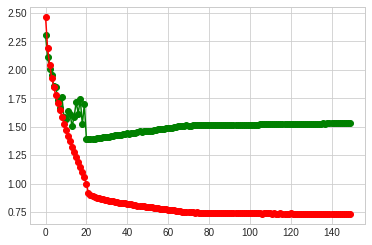

In [7]:
#sgd with 5e-3 to 20, 1e-4 to 70, then 1e-5
plt.plot(range(0,150), history.history['val_loss'], '-ok',c='g');
plt.plot(range(0,150), history.history['loss'], '-ok',c='r');

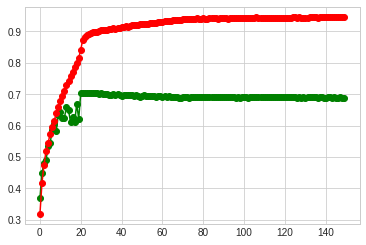

In [9]:
plt.plot(range(0,150), history.history['val_accuracy'], '-ok',c='g');
plt.plot(range(0,150), history.history['accuracy'], '-ok',c='r');

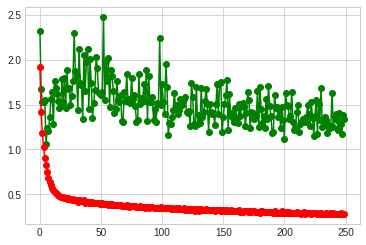

In [0]:
#adam default params
plt.plot(range(0,250), history.history['val_loss'], '-ok',c='g');
plt.plot(range(0,250), history.history['loss'], '-ok',c='r');

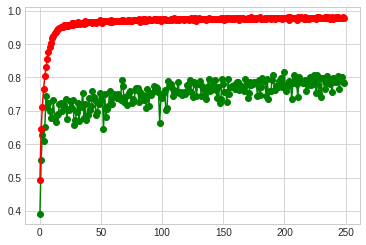

In [0]:
plt.plot(range(0,250), history.history['val_accuracy'], '-ok',c='g');
plt.plot(range(0,250), history.history['accuracy'], '-ok',c='r');

In [0]:
def scheduler(epoch):
  if epoch >= 300:
    return 1e-9
  elif epoch >=250:
    return 1e-7
  elif epoch >=200:
    return 1e-5
  elif epoch >=120:
    return 1e-4
  else:
    return 5e-3

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history2=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=250,
              validation_data=(x_test, y_test),
              callbacks=[callback],
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/250
50000/50000 [==============================] - 37s 749us/sample - loss: 2.4532 - categorical_crossentropy: 1.8464 - accuracy: 0.3266 - val_loss: 2.4030 - val_categorical_crossentropy: 1.7986 - val_accuracy: 0.3311
Epoch 2/250
50000/50000 [==============================] - 31s 621us/sample - loss: 2.1855 - categorical_crossentropy: 1.5835 - accuracy: 0.4198 - val_loss: 2.2019 - val_categorical_crossentropy: 1.6022 - val_accuracy: 0.4172
Epoch 3/250
50000/50000 [==============================] - 31s 619us/sample - loss: 2.0441 - categorical_crossentropy: 1.4468 - accuracy: 0.4774 - val_loss: 1.9955 - val_categorical_crossentropy: 1.4006 - val_accuracy: 0.4852
Epoch 4/250
50000/50000 [==============================] - 32s 639us/sample - loss: 1.9293 - categorical_crossentropy: 1.3367 - accuracy: 0.5185 - val_loss: 1.9206 - val_categorical_crossentropy: 1.3303 - val_accuracy: 0.5210
Epoch 5/250
50000/50000 [=====================

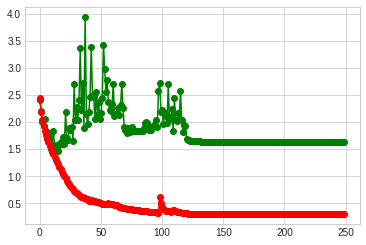

In [0]:
plt.plot(range(0,250), history2.history['val_loss'], '-ok',c='g');
plt.plot(range(0,250), history2.history['loss'], '-ok',c='r');

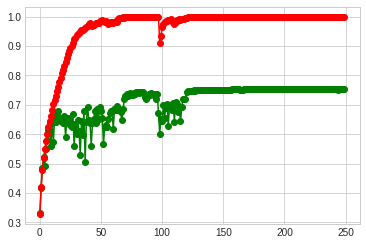

In [0]:
plt.plot(range(0,250), history2.history['val_accuracy'], '-ok',c='g');
plt.plot(range(0,250), history2.history['accuracy'], '-ok',c='r');

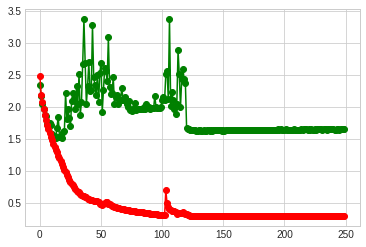

In [0]:
plt.plot(range(0,250), history.history['val_loss'], '-ok',c='g');
plt.plot(range(0,250), history.history['loss'], '-ok',c='r');

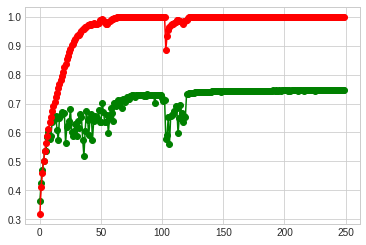

In [0]:
plt.plot(range(0,250), history.history['val_accuracy'], '-ok',c='g');
plt.plot(range(0,250), history.history['accuracy'], '-ok',c='r');

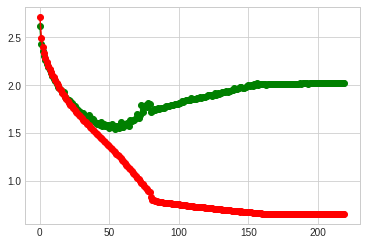

In [0]:
#previous
plt.plot(range(0,220), history.history['val_loss'], '-ok',c='g');
plt.plot(range(0,220), history.history['loss'], '-ok',c='r');

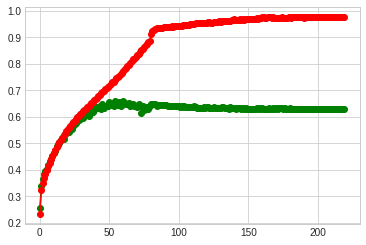

In [0]:
plt.plot(range(0,220), history.history['val_accuracy'], '-ok',c='g');
plt.plot(range(0,220), history.history['accuracy'], '-ok',c='r');

In [0]:
def scheduler(epoch):
  return 1e-9
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=300,
              validation_data=(x_test, y_test),
              callbacks=[callback],
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/300
50000/50000 [==============================] - 39s 772us/sample - loss: 0.4879 - categorical_crossentropy: 0.0095 - accuracy: 0.9991 - val_loss: 2.0693 - val_categorical_crossentropy: 1.5910 - val_accuracy: 0.6759
Epoch 2/300
50000/50000 [==============================] - 38s 762us/sample - loss: 0.4887 - categorical_crossentropy: 0.0104 - accuracy: 0.9990 - val_loss: 2.0675 - val_categorical_crossentropy: 1.5892 - val_accuracy: 0.6749
Epoch 3/300
50000/50000 [==============================] - 38s 766us/sample - loss: 0.4887 - categorical_crossentropy: 0.0103 - accuracy: 0.9988 - val_loss: 2.0654 - val_categorical_crossentropy: 1.5871 - val_accuracy: 0.6755
Epoch 4/300
50000/50000 [==============================] - 39s 770us/sample - loss: 0.4884 - categorical_crossentropy: 0.0100 - accuracy: 0.9991 - val_loss: 2.0660 - val_categorical_crossentropy: 1.5877 - val_accuracy: 0.6736
Epoch 5/300
50000/50000 [=====================

KeyboardInterrupt: ignored